In [1]:
import bw2data as bd
import bw2calc as bc
import pandas as pd
import numpy as np
from pathlib import Path
from bentso.constants import ENTSO_COUNTRIES
import bw_processing as bwp
from fs.zipfs import ZipFS
import seaborn as sb
from matplotlib import pyplot as plt
import bw2analyzer as ba

In [2]:
dp_data_dir = (Path(".").resolve().parent / "akula" / "data").resolve()
dp_data_dir

PosixPath('/Users/cmutel/Code/akula/akula/data')

In [3]:
bd.projects.set_current('GSA for archetypes')

In [4]:
ipcc = ('IPCC 2013', 'climate change', 'GWP 100a')

In [5]:
def get_one(db_name, **kwargs):
    possibles = [
        act
        for act in bd.Database(db_name)
        if all(act.get(key) == value for key, value in kwargs.items())
    ]
    if len(possibles) == 1:
        return possibles[0]
    else:
        raise ValueError(
            f"Couldn't get exactly one activity in database `{db_name}` for arguments {kwargs}"
        )

In [6]:
ch_high = get_one("ecoinvent 3.8 cutoff", name="market for electricity, high voltage", location="CH")
ch_low = get_one("ecoinvent 3.8 cutoff", name="market for electricity, low voltage", location="CH")
entso = get_one("ecoinvent 3.8 cutoff", name="market group for electricity, high voltage", location="ENTSO-E")

In [7]:
results = {}

In [8]:
ACTIVITIES = [
    ("CH HV", ch_high),
    ("CH LV", ch_low),
    ("ENTSO-E", entso),
]

In [9]:
for label, act in ACTIVITIES:
    fu, data_objs, _ = bd.prepare_lca_inputs({act: 1}, method=ipcc, remapping=False)
    lca = bc.LCA(demand=fu, data_objs=data_objs)
    lca.lci()
    lca.lcia()

    results[label + " (ecoinvent)"] = lca.score
    
    lca = bc.LCA(
        demand=fu, 
        data_objs=(
            data_objs 
            + [bwp.load_datapackage(ZipFS("../akula/data/entso-average.zip"))]
        )
    )
    lca.lci()
    lca.lcia()
    results[label + " (ENTSO-E)"] = lca.score

In [10]:
results

{'CH HV (ecoinvent)': 0.03691469259764032,
 'CH HV (ENTSO-E)': 0.13022870404278344,
 'CH LV (ecoinvent)': 0.044991177419069675,
 'CH LV (ENTSO-E)': 0.140795472432253,
 'ENTSO-E (ecoinvent)': 0.3726821019709331,
 'ENTSO-E (ENTSO-E)': 0.32566850674490405}

In [11]:
fu, data_objs, _ = bd.prepare_lca_inputs({ch_low: 1}, method=ipcc, remapping=False)
lca = bc.LCA(
    demand=fu, 
    data_objs=(
        data_objs 
        + [bwp.load_datapackage(ZipFS("../akula/data/entso-timeseries.zip"))]
    ),
    use_arrays=True,
    use_distributions=True
)
lca.lci()
lca.lcia()

In [16]:
results = [lca.score for _ in zip(range(500), lca)]

Text(16.300000000000004, 0.5, 'Probability')

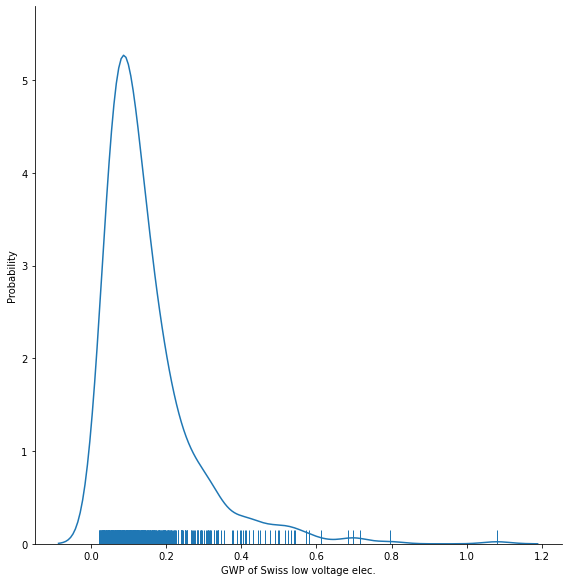

In [17]:
sb.displot(results, kind='kde', rug=True, height=8)
plt.xlabel("GWP of Swiss low voltage elec.")
plt.ylabel("Probability")